### increase ram size if required

In [ ]:
i = []
while True:
  i.append(i)

### mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import stats
from scipy.stats import entropy
from scipy.stats import ttest_ind_from_stats 
# import seaborn as sns
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [ ]:
X = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/X.npy')
y = np.load('/content/drive/MyDrive/Thesis/dataset/segmented_normalized_one_tenth/y.npy')
X.shape

(841005, 186)

In [ ]:
X = X[::10, :]
y = y[::10]
X.shape

(84101, 186)

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Thesis/mean_dataset/normalized/dataset_mean_normalized.csv', encoding='latin-1')
# dataset.head(3)
columns = dataset.iloc[:, 2:].columns.values

In [ ]:
# ////////////////////////////////// load feature and make bins /////////////////////////////////
# making 100 number of bins in the range of 1000
number_of_bins = 100
helper_scale = 1000
step = int(helper_scale/number_of_bins)
bins = np.arange(0, helper_scale, step)

# zero numpy of columns [Band, bin_num, count_pos, count_neg]
# count_arr = np.zeros((bins.shape[0] * 186, 4))
count_arr = np.array([])

label = np.array(y).reshape(-1, 1)

for ch in range(186):
    # build a dataframe of the specific band
    band = np.array(X[:,ch:ch+1])
    band = np.concatenate((band, label), axis=1)

    band = pd.DataFrame(data=band, columns=['band_val', 'label'])

    rescaled = np.array(band.band_val.values)
    max_val = np.max(rescaled)
    min_val = np.min(rescaled)
    rescaled = (rescaled - min_val) / (max_val - min_val) * helper_scale
    
    # digitize bins
    index = np.digitize(rescaled, bins)
    # insert bins to dataframe
    band.insert(2, "ind_bins", index, True)

    
    for i in range(bins.shape[0]):
        count_neg = band[band.ind_bins == i][band.label == 0].shape[0]
        count_pos = band[band.ind_bins == i][band.label == 1].shape[0]

        count = np.array([ch + 1, i, count_pos, count_neg])

        count_arr = np.append(count_arr, count)

    print(ch)

count_arr = np.reshape(count_arr, (-1, 4))
# create a dataframe of counts
df = pd.DataFrame(data=count_arr, columns=['Band', 'bin_num', 'count_pos', 'count_neg'])

# save the dataframe of counts
# df.to_csv('/content/drive/MyDrive/Thesis/files/df_class_count_' + str(number_of_bins) + 'bins.csv')

In [ ]:
# df = pd.read_csv('/content/drive/MyDrive/Thesis/files/df_class_count_100bins.csv')
# df.drop(columns='Unnamed: 0', inplace=True)
df.head(2)

,Band,bin_num,count_pos,count_neg
0,1.0,0.0,0.0,0.0
1,1.0,1.0,32.0,2.0


In [ ]:
# insert total counts
df.insert(df.shape[1], "total_counts", df.count_pos + df. count_neg)
# insert count of entropy
df.insert(df.shape[1], "ind_entropy", entropy([df.count_pos, df.count_neg], base=2)) 
# filter NaN out of the df
df.dropna(inplace=True)
# df['ind_entropy'] = df['ind_entropy'].fillna(0) not required here

# insert entropy-values column with nan
df.insert(df.shape[1], "entropy_values", value=0)
df.head(2)

/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2664: RuntimeWarning: invalid value encountered in true_divide
  pk = 1.0*pk / np.sum(pk, axis=axis, keepdims=True)


,Band,bin_num,count_pos,count_neg,total_counts,ind_entropy,entropy_values
1,1.0,1.0,32.0,2.0,34.0,0.322757,0
2,1.0,2.0,50.0,5.0,55.0,0.439497,0


In [ ]:
for i in range(186):
    bins_counts = df[df.Band == i + 1].shape[0]
    g_total_counts = df[df.Band == i + 1].total_counts.sum()
    entropy = df[df.Band == i + 1].total_counts / df[df.Band == i + 1].total_counts.sum() * df[df.Band == i + 1].ind_entropy
    df.entropy_values[df.Band == i + 1] = entropy.sum()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [ ]:
ent_df = df[['Band', 'entropy_values']].drop_duplicates(subset='Band')

In [ ]:
ent_df.insert(ent_df.shape[1], "select_band_ref", (ent_df.entropy_values - 0.5).abs())

In [ ]:
ent_df.head()

,Band,entropy_values,select_band_ref
1,1.0,0.850272,0.350272
101,2.0,0.842119,0.342119
201,3.0,0.835355,0.335355
301,4.0,0.828154,0.328154
401,5.0,0.828509,0.328509


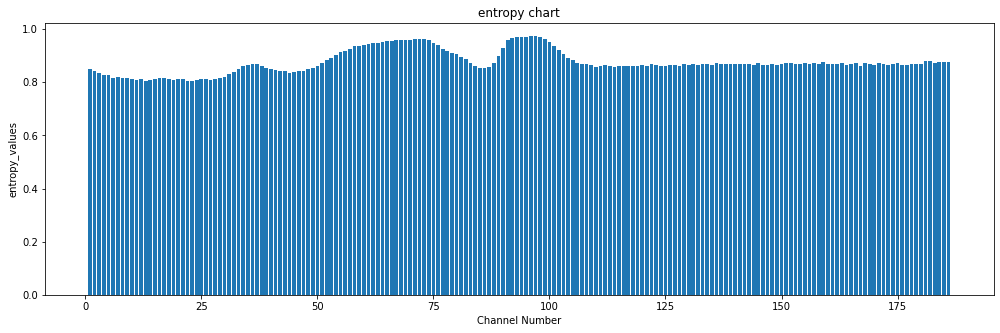

In [ ]:
plt.figure(figsize=(17, 5))
plt.bar(ent_df.Band.values, ent_df.entropy_values.values)
plt.xlabel('Channel Number')
plt.ylabel('entropy_values')
plt.title('entropy chart')
# plt.savefig('/content/drive/MyDrive/Thesis/images/entropy/entropy_raw' + '.png')
plt.show() 

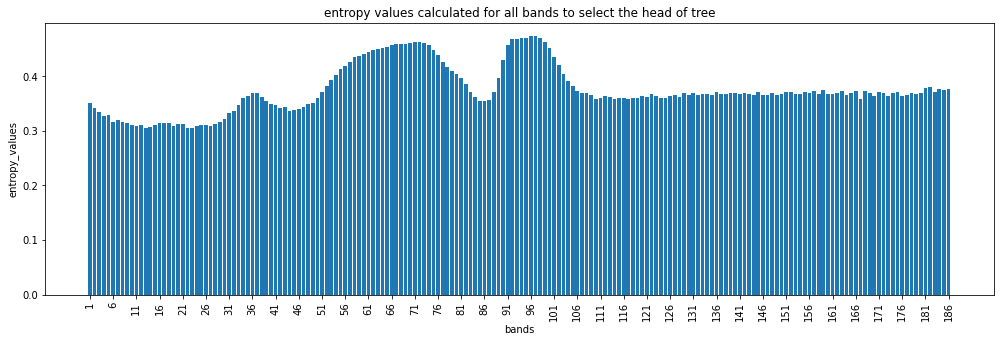

In [ ]:
plt.figure(figsize=(17, 5))
plt.bar(ent_df.Band.values, ent_df.select_band_ref.values)
plt.xlabel('bands')
plt.ylabel('entropy_values')
plt.title('entropy values calculated for all bands to select the head of tree')
plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)
# plt.savefig('/content/drive/MyDrive/Thesis/images/entropy/entropy' + '.png')
plt.show() 

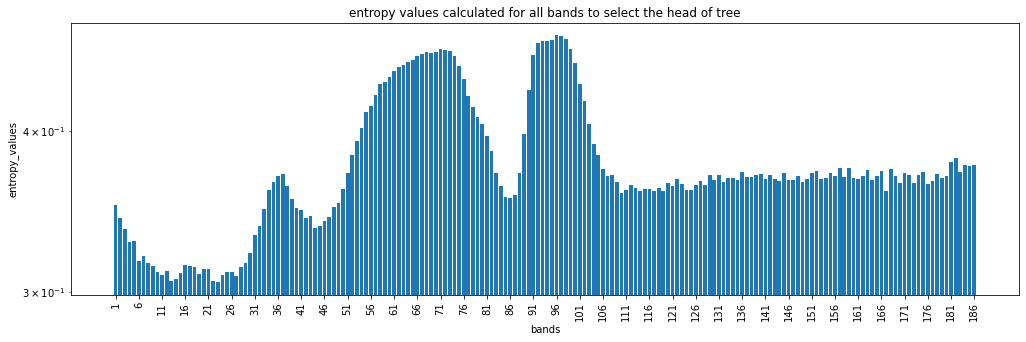

In [ ]:
plt.figure(figsize=(17, 5))
plt.yscale("log")
plt.bar(ent_df.Band.values, ent_df.select_band_ref.values)
plt.xlabel('bands')
plt.ylabel('entropy_values')
plt.title('entropy values calculated for all bands to select the head of tree')
plt.xticks(ticks=np.arange(1, 187, 5), rotation=90)
# plt.savefig('/content/drive/MyDrive/Thesis/images/entropy/entropy_log' + '.png')
plt.show() 

In [ ]:
import os, signal
os.kill(os.getpid(), signal.SIGKILL)